In [114]:
# Import Libraries
from PIL import Image
import cv2
from plantcv import plantcv as pcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [116]:
class options:
    def __init__(self):
        self.image = "IMG_1158.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "vis_nir_test_results.json"
        self.outdir = "/Users/garethtate/plantcv/naivebayesimages" # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

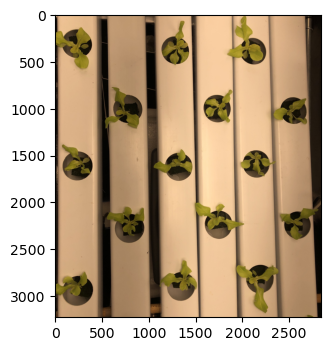

In [117]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)

In [118]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

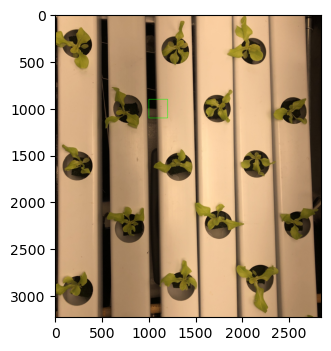

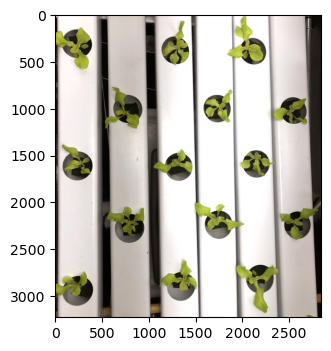

In [119]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(1000,900,200,200))

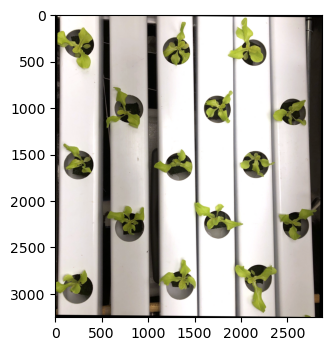

In [120]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
img1 = pcv.rotate(img=img1, rotation_deg=-0.5, crop=False)


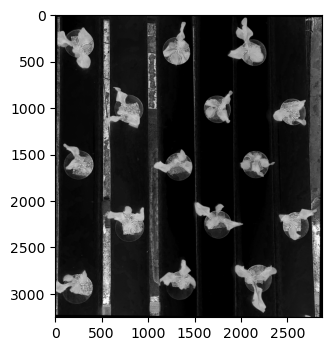

In [121]:
    # Convert RGB to HSV and extract the saturation channel

    # Inputs:
    #   rgb_image - RGB image data 
    #   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
    s = pcv.rgb2gray_hsv(rgb_img=img1, channel='s')


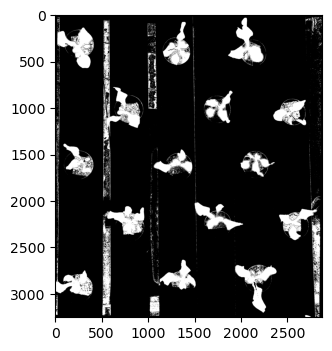

In [122]:
    # Threshold the saturation image

    # Inputs:
    #   gray_img - Grayscale image data 
    #   threshold- Threshold value (between 0-255)
    #   max_value - Value to apply above threshold (255 = white) 
    #   object_type - 'light' (default) or 'dark'. If the object is lighter than the 
    #                 background then standard threshold is done. If the object is 
    #                 darker than the background then inverse thresholding is done. 
    s_thresh = pcv.threshold.binary(gray_img=s, threshold=115, max_value=255, object_type='light')


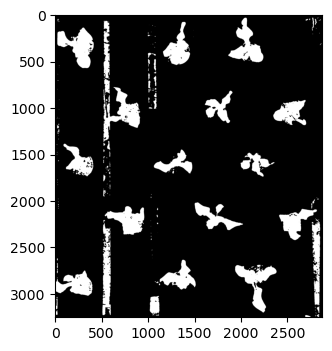

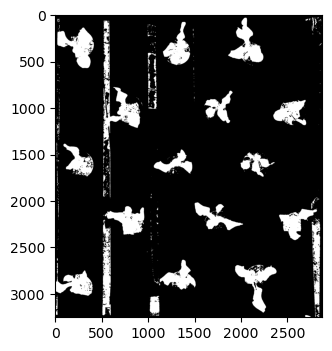

In [123]:
    # Median Blur
    # Inputs: 
    #   gray_img - Grayscale image data 
    #   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
    #           (n, m) box if tuple input 
    s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=11)
    s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=7)

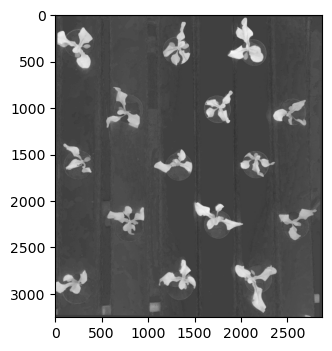

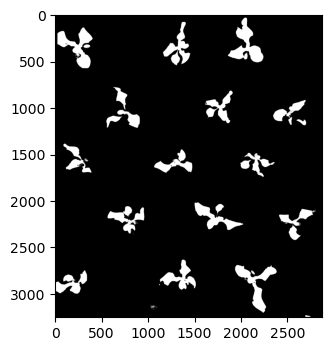

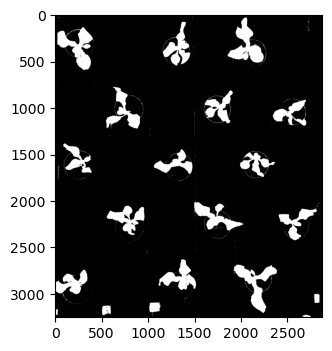

In [124]:
    # Convert RGB to LAB and extract the Blue channel

    # Input:
    #   rgb_img - RGB image data 
    #   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
    b = pcv.rgb2gray_lab(rgb_img=img1, channel='b')

    # Threshold the blue image
    b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, 
                                    object_type='light')
    b_cnt = pcv.threshold.binary(gray_img=b, threshold=140, max_value=255, 
                                 object_type='light')

    # Fill small objects (optional)
    #b_fill = pcv.fill(b_cnt, 10)

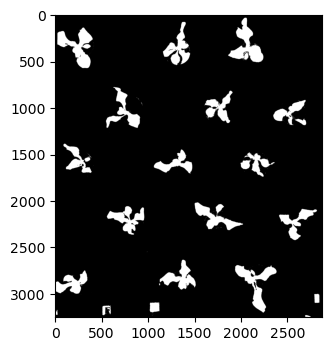

In [125]:
    # Join the thresholded saturation and blue-yellow images

    # Inputs: 
    #   bin_img1 - Binary image data to be compared to bin_img2
    #   bin_img2 - Binary image data to be compared to bin_img1
    bs = pcv.logical_and(bin_img1=s_cnt, bin_img2=b_cnt)

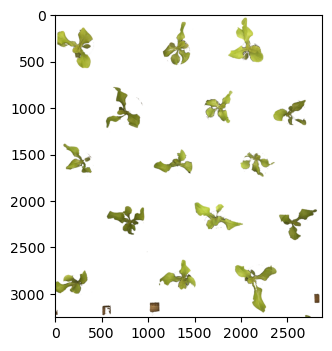

In [126]:
    # Apply Mask (for VIS images, mask_color=white)

    # Inputs:
    #   img - RGB image data 
    #   mask - Binary mask image data 
    #   mask_color - 'white' or 'black' 
    masked = pcv.apply_mask(img=img1, mask=bs, mask_color='white')

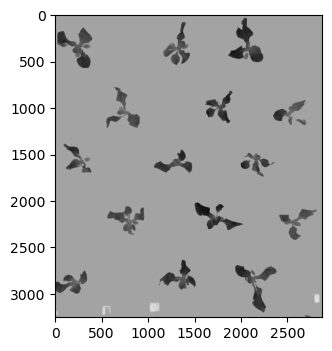

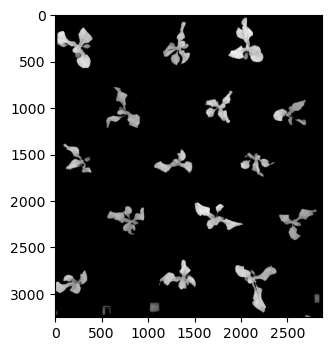

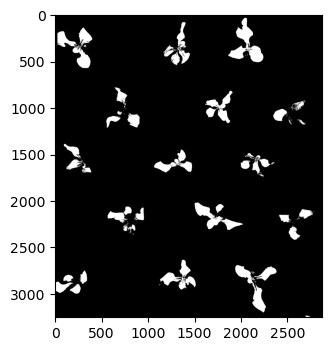

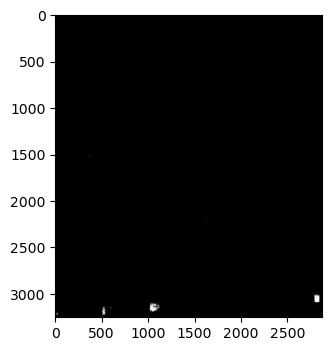

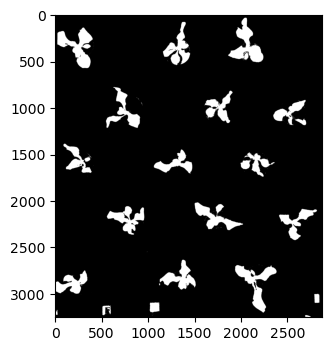

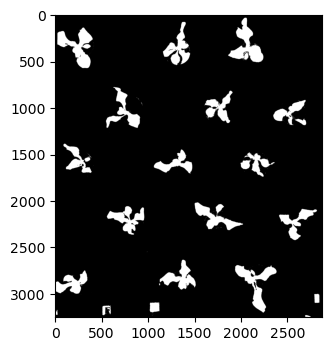

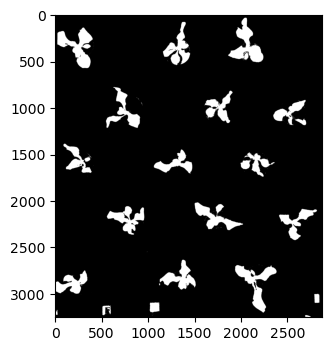

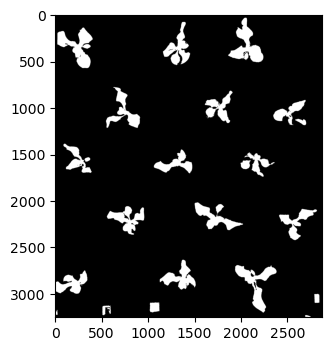

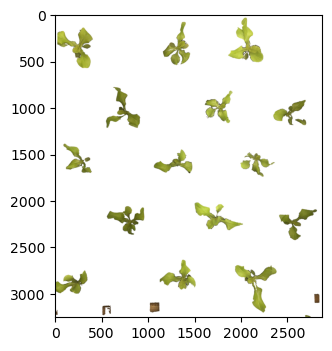

In [127]:
    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
    masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
    maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                           max_value=255, object_type='light')
    maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                          max_value=255, object_type='light')

    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
    ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

    # Fill small objects
    # Inputs: 
    #   bin_img - Binary image data 
    #   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
    ab_fill = pcv.fill(bin_img=ab, size=200)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')


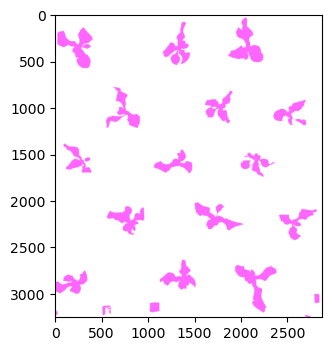

In [128]:

    # STEP 9: Find objects (contours: black-white boundaries)
    # Inputs:
    #    img  = image that the objects will be overlayed
    #    mask = what is used for object detection

    id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)


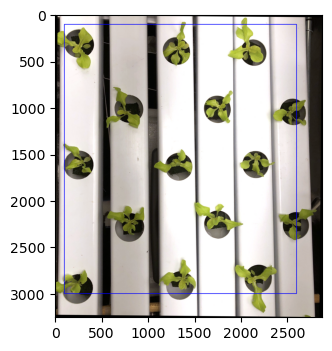

In [129]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=100, y=100, h=2900, w=2500)


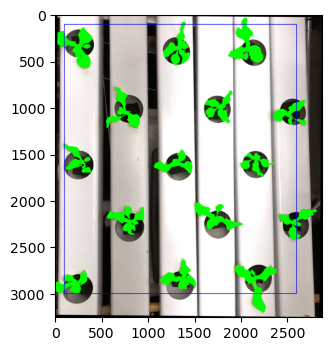

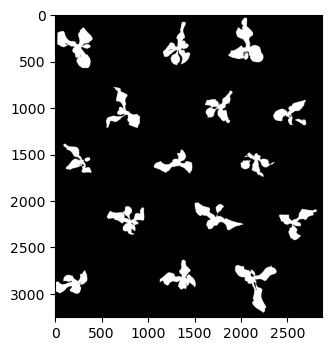

In [130]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')


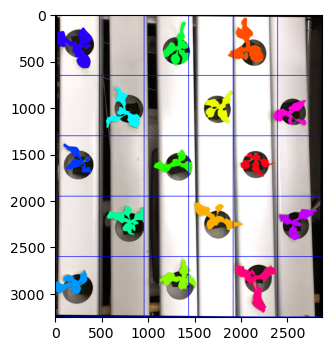

In [131]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=5, ncol=6, 
                                                         show_grid=True)


In [132]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
output_path = pcv.cluster_contour_splitimg(rgb_img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)


This function has been updated to include object hierarchy so object holes can be included
